<a href="https://colab.research.google.com/github/itz-rakshitha5/Generative-AI/blob/main/2_VAE_GEN_Variational_Autoencoder_for_CIFAR_10_Image_Generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Developing a Variational AutoEncoder to Generate New Images From CIFAR-10 Dataset**

**Step 1: Import Required Libraries**

In [1]:
import numpy as np
import tensorflow as tf
import keras
from tensorflow.keras import layers, Model
from tensorflow.keras import datasets

from tensorflow.keras.losses import MeanSquaredError, KLDivergence, binary_crossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt
import numpy as np
from numpy import cov, trace, iscomplexobj, asarray
from numpy.random import randn
from skimage.transform import resize
from scipy.linalg import sqrtm

**Step 2: Load and Preprocess CIFAR-10 Dataset**

In [2]:
(x_train, y_train), (x_test, y_test) = datasets.cifar10.load_data()

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [3]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

In [4]:
latent_dim = 1024
image_shape = x_train[0].shape
mse_loss = MeanSquaredError()
kl_loss = KLDivergence()

**Step 3: Define the Variational Autoencoder (VAE) Model & Define Custom Training Logic**

In [5]:
class VAE(keras.Model):
    def __init__(self, latent_dim, image_shape, beta):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim
        self.image_shape = image_shape
        self.beta = beta

        # Encoder
        self.encoder = tf.keras.Sequential([
            layers.Input(shape=image_shape, name="Encoder_Input_Layer"),
            layers.Conv2D(32, 3, strides=2, activation='relu', padding='same', name="Encoder_Conv2D_2"),
            layers.Conv2D(64, 3, strides=2, activation='relu', padding='same', name="Encoder_Conv2D_4"),
            layers.Conv2D(128, 3, strides=2, activation='relu', padding='same', name="Encoder_Conv2D_6"),
            layers.Flatten(name="Encoder_Flatten"),
        ])

        self.z_mean = layers.Dense(latent_dim, name="z_mean")
        self.z_log_var = layers.Dense(latent_dim, name="z_log_var")

        # Decoder
        self.decoder = tf.keras.Sequential([
            layers.InputLayer(input_shape=(latent_dim,)),
            layers.Dense(8*8*64, activation='relu'),
            layers.Reshape((8, 8, 64)),
            layers.Conv2DTranspose(64, kernel_size=3, strides=2, padding='same', activation='relu'),
            layers.Conv2DTranspose(32, kernel_size=3, strides=2, padding='same', activation='relu'),
            layers.Conv2DTranspose(3, kernel_size=3, strides=1, padding='same', activation='sigmoid'),
        ])

        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    def encode(self, data):
        x = self.encoder(data)
        z_mean, z_log_var = self.z_mean(x), self.z_log_var(x)
        return z_mean, z_log_var

    def reparameterization(self, z_mean, z_log_var):
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        z = z_mean + tf.exp(0.5 * z_log_var) * epsilon
        return z

    def call(self, x):
        mean, log_var = self.encode(x)
        z = self.reparameterization(mean, log_var)
        x_recon = self.decoder(z)
        return x_recon, mean, log_var

    def decode(self, data):
        return self.decoder(data)

    @property
    def metrics(self):
        return [self.total_loss_tracker, self.reconstruction_loss_tracker, self.kl_loss_tracker]

    def recon_loss(self, data, reconstruction):
        return tf.reduce_mean(binary_crossentropy(data, reconstruction))

    def kl_divergence(self, z_logvar, z_mu):
        kl = -0.5 * tf.reduce_mean(1 + z_logvar - z_mu**2 - tf.math.exp(z_logvar))
        return self.beta * kl

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var = self.encode(data)
            z = self.reparameterization(z_mean, z_log_var)
            reconstruction = self.decode(z)

            reconstruction_loss = self.recon_loss(data, reconstruction)
            kl_loss = self.kl_divergence(z_log_var, z_mean)
            total_loss = reconstruction_loss + kl_loss

        # ✅ Moved inside train_step
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }


**Step 4: Train the Model**

In [6]:
vae = VAE(latent_dim, image_shape, 0.3)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


In [7]:
vae.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0005))  # Lower LR for stable training
early_stopping = EarlyStopping(monitor='loss', patience=15, restore_best_weights=True, verbose=1)
history = vae.fit(x_train, epochs=50, batch_size=512, callbacks=[early_stopping])


Epoch 1/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 20s 92ms/step - kl_loss: 1.3506e-04 - loss: 0.6921 - reconstruction_loss: 0.6919
Epoch 2/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - kl_loss: 0.0044 - loss: 0.6601 - reconstruction_loss: 0.6557
Epoch 3/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - kl_loss: 0.0094 - loss: 0.6223 - reconstruction_loss: 0.6129
Epoch 4/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - kl_loss: 0.0110 - loss: 0.6187 - reconstruction_loss: 0.6077
Epoch 5/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - kl_loss: 0.0120 - loss: 0.6159 - reconstruction_loss: 0.6039
Epoch 6/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - kl_loss: 0.0130 - loss: 0.6124 - reconstruction_loss: 0.5993
Epoch 7/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - kl_loss: 0.0134 - loss: 0.6116 - reconstruction_loss: 0.5982
Epoch 8/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - kl_loss: 0.0137 - loss: 0.6108 - reconstruction_loss: 0.5971
Epoch 9/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - kl_loss: 0.0140 - loss: 0.6098

**Step 5: Generate New Images from Latent Space**

In [8]:
def generate_images_from_latent_vectors(vae, num_images_to_generate):
  random_latent_vectors = np.random.randn(num_images_to_generate, vae.latent_dim)

  generated_images = vae.decoder.predict(random_latent_vectors)

  return generated_images
generated_images = generate_images_from_latent_vectors(vae, 20)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 518ms/step


**Step 6: Visualize Real and Generated Images**

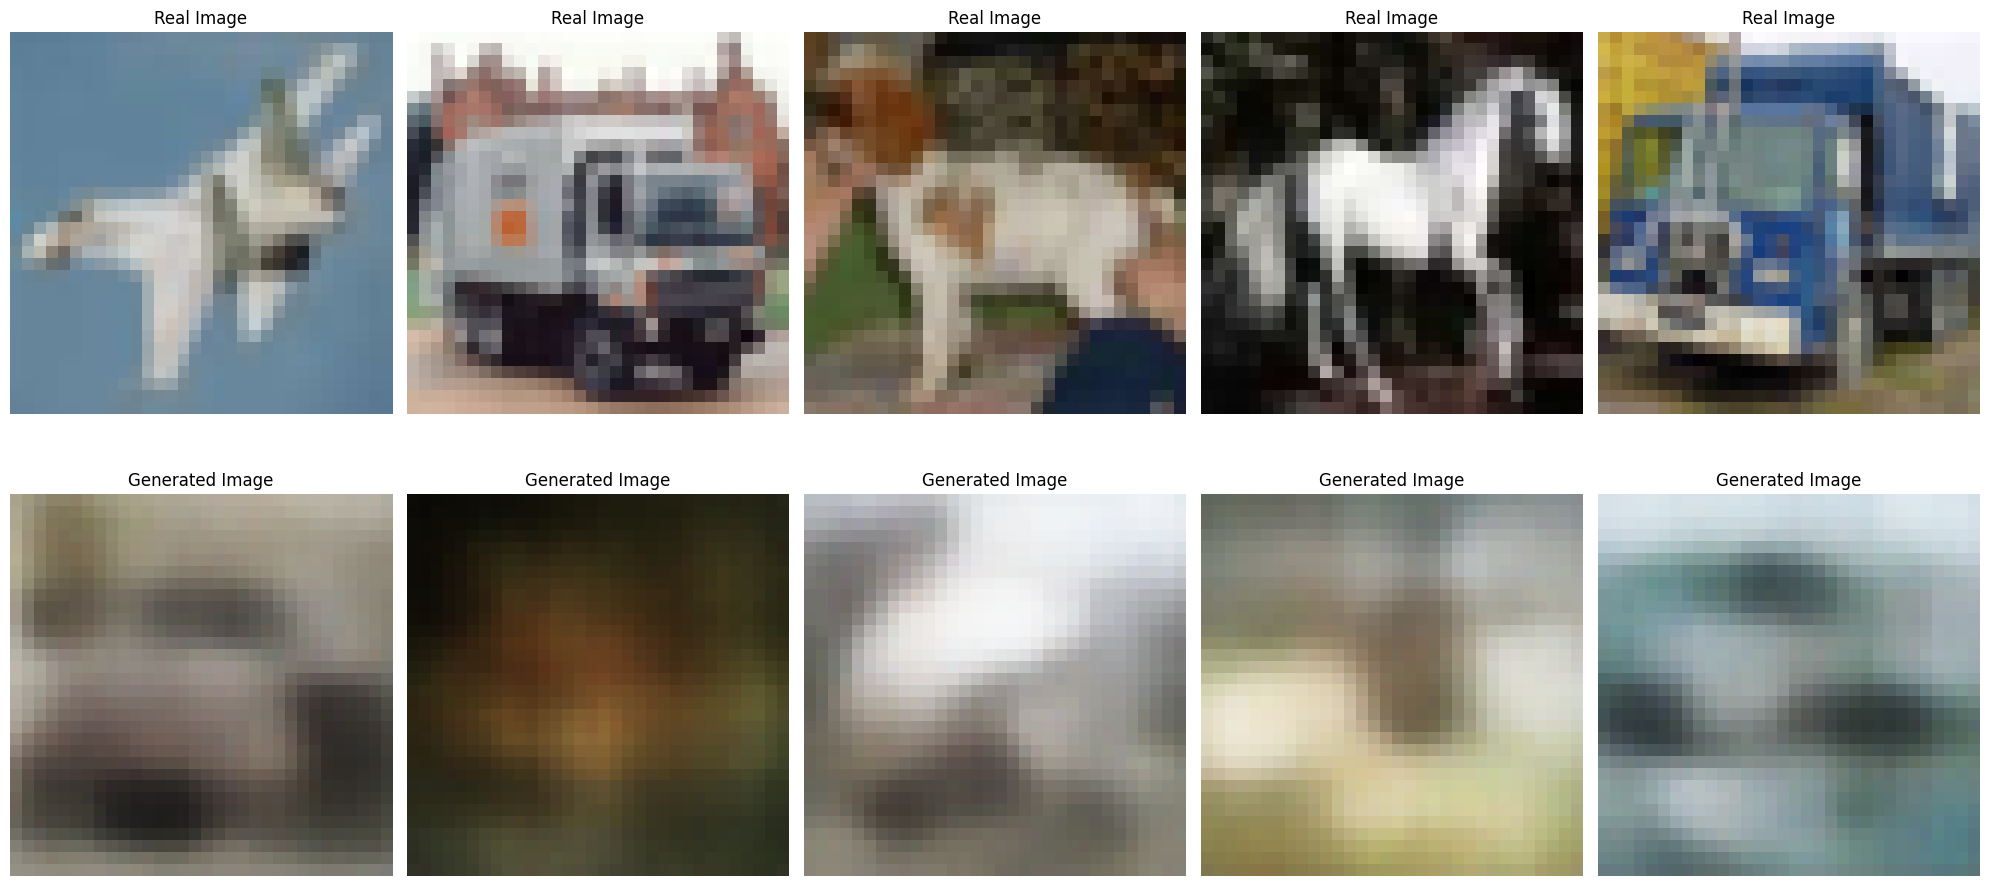

In [9]:
def plot_real_and_generated_images(real_images, generated_images, num_images_to_generate):
    plt.figure(figsize=(20,10))  # Indented this line by 4 spaces
    for i in range(num_images_to_generate):
        plt.subplot(2, num_images_to_generate, i+1)
        plt.imshow(real_images[i+10])
        plt.title("Real Image")
        plt.axis('off')

    for i in range(num_images_to_generate):
        plt.subplot(2, num_images_to_generate, num_images_to_generate+i+1)
        plt.imshow(generated_images[i])
        plt.title("Generated Image")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

plot_real_and_generated_images(x_test, generated_images, 5)

In [9]:
kl_loss = history.history['kl_loss']
reconstruction_loss = history.history['reconstruction_loss']
total_loss = history.history['loss'] # Changed 'total_loss' to 'loss'

epochs = range(1, len(kl_loss) + 1)

plt.figure(figsize=(5, 3))
plt.plot(epochs, kl_loss, 'b', label='KL Loss')
plt.plot(epochs, reconstruction_loss, 'r', label='Reconstruction Loss')
plt.plot(epochs, total_loss, 'g', label='Total Loss')
plt.title('Training Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()